In [1]:
import pdb
import ipdb

from transformers import BertTokenizer, BertPreTrainedModel
from transformers import AdamW, EarlyStoppingCallback
from transformers import TrainingArguments, Trainer, TrainerCallback
from transformers import BertModel, BertLayer
from transformers.modeling_outputs import SequenceClassifierOutput

import pandas as pd
import numpy as np
from datasets import load_dataset
from torch import nn
import numpy

import math
import os
import warnings
import random
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from scipy.stats import pearsonr, spearmanr

import torch
import torch.utils.checkpoint
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

%matplotlib inline 
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
task = pd.read_csv("/home/sdlee130/layer_attention/GLUE_pred/general/input_attention/attention_weight.csv", index_col=0)
task_uf = pd.read_csv("/home/sdlee130/layer_attention/GLUE_pred/general/input_attention/attention_weight_unFT.csv", index_col=0)
# attention_weight_unFT

In [3]:
x = range(1, 13, 1)
y = task
y_uf = task_uf
task_li = ['CoLA', 'SST-2', 'MRPC', 'STS-B', 'QQP', 'MNLI-m', 'AX', 'MNLI-mm',
          'QNLI', 'RTE', 'WNLI']

In [4]:
y

,CoLA,SST-2,MRPC,STS-B,QQP,MNLI-m,AX,MNLI-mm,QNLI,RTE,WNLI
0,0.086851,0.090300,0.104098,0.110581,0.097360,0.101348,0.111865,0.101887,0.086748,0.092231,0.098693
1,0.094735,0.098292,0.113414,0.114885,0.102697,0.108109,0.119311,0.108885,0.097096,0.101262,0.108405
2,0.089051,0.094466,0.106678,0.110771,0.097538,0.100343,0.111013,0.101141,0.094629,0.096779,0.104760
3,0.124692,0.139483,0.140924,0.156291,0.155063,0.151184,0.165153,0.152032,0.149660,0.143805,0.154240
4,0.136996,0.148863,0.146859,0.148015,0.150183,0.146206,0.153590,0.146646,0.145462,0.147105,0.152244
5,0.124499,0.128979,0.106737,0.084435,0.113223,0.104221,0.085681,0.103627,0.117285,0.115033,0.104972
6,0.100416,0.095857,0.074956,0.059654,0.079607,0.077435,0.064785,0.076674,0.084437,0.091550,0.077331
7,0.065081,0.062322,0.055783,0.047746,0.060636,0.063688,0.054174,0.062959,0.067227,0.065052,0.054229
8,0.053371,0.046682,0.044178,0.041923,0.043652,0.047423,0.042556,0.046824,0.048720,0.043889,0.040326
9,0.053789,0.041676,0.038925,0.044274,0.035897,0.039660,0.036820,0.039181,0.045836,0.036525,0.038892


In [5]:
y_uf

,CoLA,SST-2,MRPC,STS-B,QQP,MNLI-m,MNLI-mm,AX,QNLI,RTE,WNLI
0,0.131264,0.079050,0.078122,0.055028,0.072612,0.092486,0.097826,0.124782,0.085466,0.078283,0.074905
1,0.069519,0.120473,0.051343,0.066132,0.095905,0.077463,0.083795,0.105215,0.111493,0.104144,0.101542
2,0.073872,0.138655,0.036571,0.069424,0.104365,0.068594,0.072129,0.087826,0.129312,0.119810,0.111767
3,0.078914,0.204645,0.041388,0.068969,0.150891,0.124680,0.129774,0.161165,0.177388,0.174221,0.167906
4,0.049155,0.099066,0.042040,0.108254,0.125376,0.124887,0.126213,0.159640,0.119529,0.115463,0.112895
5,0.038656,0.075383,0.061503,0.065082,0.092637,0.188526,0.191467,0.142862,0.102271,0.079961,0.063565
6,0.064618,0.051014,0.063423,0.063715,0.042705,0.165221,0.160684,0.127574,0.046550,0.062999,0.056839
7,0.051147,0.039959,0.103507,0.095696,0.023294,0.066973,0.059455,0.037365,0.029712,0.035774,0.033056
8,0.071712,0.044154,0.136820,0.105658,0.033839,0.027542,0.024382,0.015657,0.039070,0.050517,0.057471
9,0.094086,0.036485,0.157568,0.091353,0.049653,0.022757,0.019262,0.014301,0.034014,0.047703,0.062873


<Figure size 1200x900 with 0 Axes>

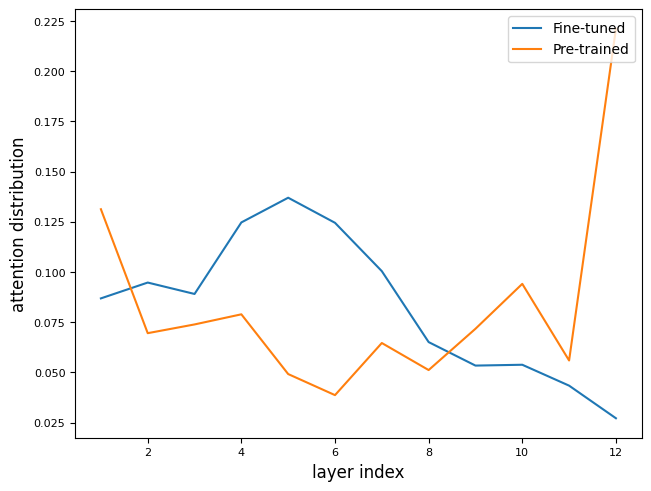

In [17]:
plt.figure(figsize=(12, 9))
plt.subplots(constrained_layout=True)
for i in range(len(task_li)):
    # 'CoLA', 'SST-2', 'MRPC', 'STS-B', 'QQP', 
    # 'MNLI-m', 'AX', 'MNLI-mm',
    # 'QNLI', 'RTE', 'WNLI'
    #if task_li[i] =='QNLI' or task_li[i] == 'SST-2' or task_li[i] == 'MRPC':# or task_li[i] == 'WNLI' or task_li[i] == 'QQP':
    #    plt.subplot(2, 1, 1)
    #elif task_li[i] == 'WNLI':
    #    plt.subplot(3, 1, 2)
    #else:
    #    plt.subplot(2, 1, 2)
    #plt.subplot(3, 4, i+1)
    if task_li[i] == 'CoLA':
        plt.style.use('default')
        #plt.rcParams['figure.figsize'] = (4, 3)
        plt.rcParams['font.size'] = 8

        plt.plot(x, y[task_li[i]], label='Fine-tuned')#, color = 'r') #, linestyle='', marker=''
        plt.plot(x, y_uf[task_li[i]], label='Pre-trained')#, color = 'b')
        #plt.ylim([0.02, 0.16])

        plt.legend(loc='upper right', fontsize=10)

        #plt.title("attention of " + str(i) + "-th layer")
        plt.xlabel("layer index", fontsize=12)
        plt.ylabel("attention distribution", fontsize=12)

plt.savefig('attn_weight.png')

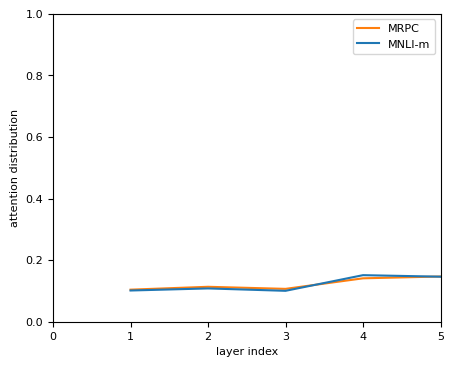

In [7]:
plt.figure(figsize=(5,4))

for i in range(len(task_li)):
    # 'CoLA', 'SST-2', 'MRPC', 'STS-B', 'QQP', 
    # 'MNLI-m', 'AX', 'MNLI-mm',
    # 'QNLI', 'RTE', 'WNLI'
    if task_li[i] =='MRPC':
        plt.subplot(1, 1, 1)
        #plt.title("bert-base-uncased", fontsize=13)
        plt.plot(x, y[task_li[i]], label=task_li[i], color='tab:orange') #, linestyle='', marker=''
    elif task_li[i] == 'MNLI-m':
        plt.subplot(1, 1, 1)
        plt.plot(x, y[task_li[i]], label=task_li[i], color='tab:blue') #, linestyle='', marker=''
    else: 
        continue
    
    plt.style.use('default')
    #plt.rcParams['figure.figsize'] = (4, 3)
    plt.rcParams['font.size'] = 6
    plt.xlim([0, 5])
    plt.ylim([0, 1.0])
    
    plt.legend(loc='upper right', fontsize=8)
    #plt.title("attention of " + str(i) + "-th layer")
    plt.xlabel("layer index", fontsize=8)
    plt.ylabel("attention distribution", fontsize=8)
    
plt.savefig('attn_weight.png')

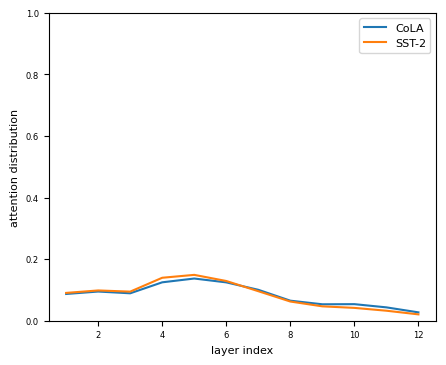

In [8]:
plt.figure(figsize=(5, 4))
for i in range(len(task_li)):
    if task_li[i] =='CoLA' or task_li[i] == 'SST-2':
        plt.subplot(1, 1, 1)
        plt.plot(x, y[task_li[i]], label=task_li[i])
    #elif task_li[i] == 'STS-B':
        #plt.subplot(1, 2, 2)
        #continue
    #else:
        #plt.subplot(1, 1, 1)
        #plt.plot(x, y[task_li[i]], label=task_li[i])
    
    plt.style.use('default')
    #plt.rcParams['figure.figsize'] = (4, 3)
    plt.rcParams['font.size'] = 6
    
    #plt.plot(x, y[task_li[i]], label=task_li[i]) #, linestyle='', marker=''
    plt.ylim([0, 1.0])
    
    plt.legend(loc='upper right', fontsize=8)
    #plt.title("attention of " + str(i) + "-th layer")
    plt.xlabel("layer index", fontsize=8)
    plt.ylabel("attention distribution", fontsize=8)
plt.savefig('attn_weight.png')

In [9]:
input_pivot = [[39.5, 43.5, 43.2, 44.2],[90.6, 91.6, 91.5, 92.4],[82.0, 83.2, 83.2, 83.5],
               [74.8, 76.6, 76.6, 76.8],[81.6, 82.3, 82.9, 83.4],[79.9, 80.9, 81.5, 81.8],
               [69.4, 71.1, 71.1, 71.2],[87.5, 88.5, 88.6, 88.8],[80.8, 83.9, 83.5, 83.5],
               [79.6, 83.0, 82.6, 82.6],[87.4, 89.3, 89.2, 89.3],[61.5, 62.7, 63.2, 62.9],
               [65.1, 65.1, 63.0, 65.1],[29.8, 33.3, 33.7, 31.6],[73.5, 75.2, 75.0, 75.5]]

last_pivot = [[46.9, 44.1, 44.2, 42.2],[91.7, 92.3, 91.5, 92.4],[78.2, 83.3, 83.2, 81.6],
              [71.3, 76.6, 76.6, 74.8],[83.2, 82.9, 82.9, 84.1],[81.9, 81.4, 81.6, 82.9],
              [71.1, 71.0, 71.1, 71.3],[88.7, 88.4, 88.6, 88.7],[83.2, 83.9, 83.6, 83.7],
              [82.4, 82.9, 82.6, 82.6],[89.0, 89.1, 89.2, 90.0],[60.4, 61.9, 63.2, 61.4],
              [54.1, 63.0, 63.0, 53.4],[32.0, 32.7, 33.5, 32.2],[73.6, 75.1, 75.1, 73.8]]

mean_pivot = [[42.6, 44.8, 43.8, 42.1],[92.1, 92.0, 91.5, 92.5],[83.4, 82.9, 83.3, 82.1],
              [76.8, 76.5, 76.6, 75.4],[82.8, 83.0, 82.9, 83.5],[81.2, 81.6, 81.5, 81.8],
              [70.4, 70.8, 71.1, 71.4],[88.1, 88.3, 88.6, 89.0],[82.9, 83.5, 83.5, 83.7],
              [82.4, 82.8, 82.5, 82.5],[89.2, 89.2, 89.1, 89.6],[63.7, 63.1, 63.2, 62.3],
              [50.7, 63.7, 63.0, 65.1],[31.6, 33.6, 33.8, 31.7],[73.6, 75.3, 75.1, 75.1]]

In [10]:
input_mean = []
input_std = []
for i in range(len(input_pivot)):
    input_mean.append(numpy.mean(input_pivot[i]))
    input_std.append(numpy.std(input_pivot[i]))
last_mean = []
last_std = []
for i in range(len(last_pivot)):
    last_mean.append(numpy.mean(last_pivot[i]))
    last_std.append(numpy.std(last_pivot[i]))
mean_mean = []
mean_std = []
for i in range(len(mean_pivot)):
    mean_mean.append(numpy.mean(mean_pivot[i]))
    mean_std.append(numpy.std(mean_pivot[i]))
    
glue_task = ['CoLA', 'SST-2', 'MRPC_f1', 'MRPC_acc', 'STS-B_pco', 
             'STS-B_spco', 'QQP_f1', 'QQP_acc', 'MNLI-m', 'MNLI-mm',
             'QNLI', 'RTE', 'WNLI', 'AX', 'GLUE_score']

In [11]:
for i in range(len(input_mean)):
    print(input_mean[i], input_std[i])

42.6 1.826198236774968
91.525 0.6378675411086575
82.975 0.5760859310901462
76.19999999999999 0.8124038404635953
82.55 0.6726812023536903
81.025 0.7258615570478956
70.7 0.7516648189186419
88.35000000000001 0.5024937810560431
82.925 1.2376893794486585
81.94999999999999 1.366565036871646
88.8 0.8093207028119292
62.575 0.6456585785072485
64.57499999999999 0.9093266739736582
32.1 1.5443445211480498
74.8 0.771362431027076


In [12]:
for i in range(len(last_mean)):
    print(last_mean[i], last_std[i])

44.349999999999994 1.6740669042783192
91.975 0.38324274291889776
81.57499999999999 2.0620075169601093
74.82499999999999 2.1637640814099846
83.275 0.4918078893226454
81.95 0.5766281297335415
71.125 0.10897247358851635
88.60000000000001 0.12247448713915775
83.60000000000001 0.25495097567964004
82.625 0.17853571071357205
89.325 0.39607448794387207
61.725 1.0084022015049368
58.375 4.631616888301536
32.6 0.5787918451395109
74.39999999999999 0.7035623639735138


In [13]:
for i in range(len(mean_mean)):
    print(mean_mean[i], mean_std[i])

43.324999999999996 1.0520812706250386
92.025 0.3561951712193749
82.92500000000001 0.511737237261471
76.325 0.5448623679425805
83.05000000000001 0.2692582403567251
81.525 0.2165063509461072
70.925 0.36996621467371793
88.5 0.33911649915626507
83.4 0.2999999999999983
82.55 0.14999999999999739
89.275 0.19202864369671355
63.075 0.5018714974971205
60.625 5.779868078079288
32.675 1.0280442597476038
74.77499999999999 0.683282518435823


<Figure size 1000x1000 with 0 Axes>

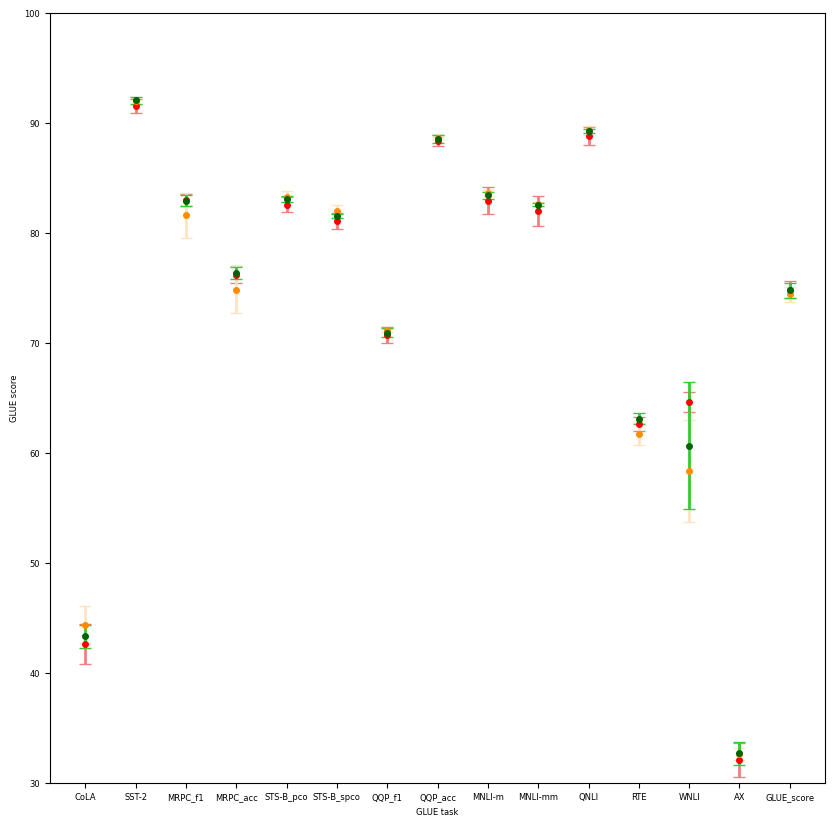

In [14]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
fig, ax = plt.subplots()
bar_width = 0.25
 
ax.errorbar(range(15), 
             input_mean, 
             yerr=input_std,
            fmt='o',
            color='red', ecolor='lightcoral',
            elinewidth=2, capsize=4, markersize=4)

ax.errorbar(range(15), 
             last_mean, 
             yerr=last_std,
            fmt='o',
            color='darkorange', ecolor='bisque',
            elinewidth=2, capsize=4, markersize=4)

ax.errorbar(range(15), 
             mean_mean, 
             yerr=mean_std,
            fmt='o',
            color='darkgreen', ecolor='limegreen',
            elinewidth=2, capsize=4, markersize=4)

ax.set_ylabel('GLUE score')
ax.set_xlabel("GLUE task")

plt.xticks(range(15), glue_task)

plt.ylim(30, 100)
plt.show()